# Data Preprocessing of Bitcoin Price and Building Neural Networks #
In this notebook we will process the Bitcoin data into daily data. The Bitcoin historical dataset is structured by the minute, that is every row in the dataset represents the Bitcoign price and volume for that minute. We will use the original dataset to create a new dataset that has a row for each day with price and volume metrics calculated for that day.  

In [78]:
# importing libraries
import pandas as pd
import numpy as np
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib import style
style.use('fivethirtyeight')

In [3]:
# defining the directory path to the historical bitcoin dataset
path = 'kaggle/input/'
file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv'
full_path = path + file_name
bitcoinData = pd.read_csv(full_path)

bitcoinData.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# calculate report for the number of null values and what percentage of values are null.
# Null values make up 95% of the entries for the first 500,000 minutes which is 347 days or about 1 year.
# In the beginning the dataset is sparse, because the bitcoin blockchain updated infrequently.
null_values = bitcoinData.loc[:500000].isnull().sum()
null_per = ( null_values /500000) * 100

report = pd.concat([null_values, null_per], axis = 1, ignore_index = True) 

report.rename(columns={ 0: '#', 1: '%' }, inplace = True)

report

,#,%
Timestamp,0,0.000
Open,475480,95.096
High,475480,95.096
Low,475480,95.096
Close,475480,95.096
Volume_(BTC),475480,95.096
Volume_(Currency),475480,95.096
Weighted_Price,475480,95.096


In [5]:
# During the second 500,000 minutes the null values drop to 45%. The dataset increases in density as time
# goes on. 
null_values = bitcoinData.loc[500000:1000000].isnull().sum()
null_per = ( null_values /500000) * 100

report = pd.concat([null_values, null_per], axis = 1, ignore_index = True) 

report.rename(columns={ 0: '#', 1: '%' }, inplace = True)

report

,#,%
Timestamp,0,0.0000
Open,228566,45.7132
High,228566,45.7132
Low,228566,45.7132
Close,228566,45.7132
Volume_(BTC),228566,45.7132
Volume_(Currency),228566,45.7132
Weighted_Price,228566,45.7132


In [6]:
# renaming columns of dataset
bitcoinData = bitcoinData.rename(columns = {
    'Volume_(BTC)':'VolumeBTC',
    'Volume_(Currency)':'VolumeCurrency',
    'Weighted_Price':'WeightedPrice'
})

# convert Timestamp to a date
bitcoinData['Timestamp'] = pd.to_datetime( bitcoinData['Timestamp'], unit = 's' )

In [7]:
# remove rows with null values from the dataframe, leaving only rows that are populated with data.
bitcoinData = bitcoinData.dropna(how='all', subset=['Open','High','Low','Close','WeightedPrice'])
print('Dataframe rows after dropping null values:', bitcoinData.shape[0])
bitcoinData.head(15)

Dataframe rows after dropping null values: 3484305


,Timestamp,Open,High,Low,Close,VolumeBTC,VolumeCurrency,WeightedPrice
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
1896,2012-01-01 15:28:00,4.84,4.84,4.84,4.84,10.000000,48.400000,4.840000
2333,2012-01-01 22:45:00,5.00,5.00,5.00,5.00,10.100000,50.500000,5.000000
3612,2012-01-02 20:04:00,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000
4553,2012-01-03 11:45:00,5.32,5.32,5.32,5.32,2.419173,12.870000,5.320000
4710,2012-01-03 14:22:00,5.14,5.14,5.14,5.14,0.680000,3.495200,5.140000


In [8]:
# no remaining null values in any column for any row
bitcoinData.isnull().any()

Timestamp         False
Open              False
High              False
Low               False
Close             False
VolumeBTC         False
VolumeCurrency    False
WeightedPrice     False
dtype: bool

## Reducing data down to daily points ##

The original datapoints are minute by minute. We will condense these to daily datapoints and calculate a daily average for the wieghted price, a percent change (that is what percentage the price has changed from the previous day to teh current day) and also rolling averages of 5 days, 10 days, and 20 days.

In [9]:
# function to translate Timestamp time into a Date, i.e. the function drops the hour, minute, and seconds
def getDate(dt):
    s = dt.year + '-' + dt.month + '-' + dt.day
    return datetime.strptime(s, '%Y-%m-%d')

# Create a Date column that contains the calendar date.
bitcoinData['Date'] = bitcoinData['Timestamp'].apply(datetime.date)

bitcoinData.head()

,Timestamp,Open,High,Low,Close,VolumeBTC,VolumeCurrency,WeightedPrice,Date
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


In [10]:
# Create a distinct Pandas DataFrame that has rows for each Date.
dailyData = bitcoinData.groupby(['Date']).mean()
dailyData.head()

,Open,High,Low,Close,VolumeBTC,VolumeCurrency,WeightedPrice
Date,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [11]:
# Calculate the Opening and Closing prices for each day. 
# A date's opening price is the opening price of the first minute of that date. A date's closing price
# is the closing price for the last minute of that date.
indexOpen = pd.DataFrame(bitcoinData.groupby(['Date'])['Timestamp'].min())
indexClose = pd.DataFrame(bitcoinData.groupby(['Date'])['Timestamp'].max())

indexOpen = pd.merge(indexOpen, bitcoinData[['Date','Timestamp','Open']], how='left', on=['Date','Timestamp']).drop(['Timestamp'], axis=1)
indexClose = pd.merge(indexClose, bitcoinData[['Date','Timestamp','Open']], how='left', on=['Date','Timestamp']).drop(['Timestamp'], axis=1)

#Merge the indexOpen and indexClose dataframes into columns for the dailyData dataframe.
dailyData = pd.merge(indexOpen, indexClose, how='inner', on=['Date'])
dailyData = dailyData.rename(columns={'Open_x':'Open', 'Open_y':'Close'})

# set the index of dailyData dataframe to the be the 'Date' column.
dailyData = dailyData.set_index('Date')

In [12]:
# Function to calculate the weighted average for each day. The function takes the prices at
# every minute of the date and averages them weighted on trading volume
def dailyWeightAvg(dayGroup, volCol, wPriceCol):
    vol = dayGroup[volCol]
    price = dayGroup[wPriceCol]
    
    return ((vol * price).sum())/(vol.sum())

# Find the maximum price for each date and store it in the 'High' column. Find the minimum price
# for each date and store it in the 'Low' column.
dailyData['High'] = bitcoinData.groupby(['Date'])['High'].max()
dailyData['Low'] = bitcoinData.groupby(['Date'])['Low'].min()

# The total trading volume for a date is the sum of trading volume for all minutes in the date.
dailyData['VolumeBTC'] = bitcoinData.groupby(['Date'])['VolumeBTC'].sum()
dailyData['VolumeCurrency'] = bitcoinData.groupby(['Date'])['VolumeCurrency'].sum()

# Calculate the daily average weighted by trading volume for each date and store is in 'WeightedDailyAvg' column.
dailyData['WeightedDailyAvg'] = bitcoinData.groupby(['Date']).apply(dailyWeightAvg, 'VolumeBTC', 'WeightedPrice')

#reset the index to index numbers
dailyData = dailyData.reset_index()

dailyData.head()

,Date,Open,Close,High,Low,VolumeBTC,VolumeCurrency,WeightedDailyAvg
0,2011-12-31,4.39,4.58,4.58,4.39,95.317878,425.320338,4.462126
1,2012-01-01,4.58,5.00,5.00,4.58,21.602000,105.779160,4.896730
2,2012-01-02,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000
3,2012-01-03,5.32,5.29,5.32,5.14,88.037281,464.805210,5.279641
4,2012-01-04,4.93,5.37,5.57,4.93,107.233260,568.076197,5.297575


In [13]:
#calculate percent change of price for each day
dailyData['PercentChange'] = (((dailyData['WeightedDailyAvg']/dailyData['WeightedDailyAvg'].shift(periods=1))-1)*100)

#calculating rolling averages
# calculate a 5 day rolling average
dailyData['5DayAvg'] = ((dailyData.WeightedDailyAvg*dailyData.VolumeBTC+
                        dailyData.WeightedDailyAvg.shift(periods=1)*dailyData.VolumeBTC.shift(periods=1)+
                        dailyData.WeightedDailyAvg.shift(periods=2)*dailyData.VolumeBTC.shift(periods=2)+
                        dailyData.WeightedDailyAvg.shift(periods=3)*dailyData.VolumeBTC.shift(periods=3)+
                        dailyData.WeightedDailyAvg.shift(periods=4)*dailyData.VolumeBTC.shift(periods=4))/
                        (dailyData.VolumeBTC+
                         dailyData.VolumeBTC.shift(periods=1)+
                         dailyData.VolumeBTC.shift(periods=2)+
                         dailyData.VolumeBTC.shift(periods=3)+
                         dailyData.VolumeBTC.shift(periods=4)))

# calculate a 10 day rolling average
dailyData['10DayAvg'] = ((dailyData.WeightedDailyAvg*dailyData.VolumeBTC+
                        dailyData.WeightedDailyAvg.shift(periods=1)*dailyData.VolumeBTC.shift(periods=1)+
                        dailyData.WeightedDailyAvg.shift(periods=2)*dailyData.VolumeBTC.shift(periods=2)+
                        dailyData.WeightedDailyAvg.shift(periods=3)*dailyData.VolumeBTC.shift(periods=3)+
                        dailyData.WeightedDailyAvg.shift(periods=4)*dailyData.VolumeBTC.shift(periods=4)+
                        dailyData.WeightedDailyAvg.shift(periods=5)*dailyData.VolumeBTC.shift(periods=5)+
                        dailyData.WeightedDailyAvg.shift(periods=6)*dailyData.VolumeBTC.shift(periods=6)+
                        dailyData.WeightedDailyAvg.shift(periods=7)*dailyData.VolumeBTC.shift(periods=7)+
                        dailyData.WeightedDailyAvg.shift(periods=8)*dailyData.VolumeBTC.shift(periods=8)+
                        dailyData.WeightedDailyAvg.shift(periods=9)*dailyData.VolumeBTC.shift(periods=9))/
                        (dailyData.VolumeBTC+
                         dailyData.VolumeBTC.shift(periods=1)+
                         dailyData.VolumeBTC.shift(periods=2)+
                         dailyData.VolumeBTC.shift(periods=3)+
                         dailyData.VolumeBTC.shift(periods=4)+
                         dailyData.VolumeBTC.shift(periods=5)+
                         dailyData.VolumeBTC.shift(periods=6)+
                         dailyData.VolumeBTC.shift(periods=7)+
                         dailyData.VolumeBTC.shift(periods=8)+
                         dailyData.VolumeBTC.shift(periods=9)))

# calculate a 20 day rolling average
dailyData['20DayAvg'] = ((dailyData.WeightedDailyAvg*dailyData.VolumeBTC+
                        dailyData.WeightedDailyAvg.shift(periods=1)*dailyData.VolumeBTC.shift(periods=1)+
                        dailyData.WeightedDailyAvg.shift(periods=2)*dailyData.VolumeBTC.shift(periods=2)+
                        dailyData.WeightedDailyAvg.shift(periods=3)*dailyData.VolumeBTC.shift(periods=3)+
                        dailyData.WeightedDailyAvg.shift(periods=4)*dailyData.VolumeBTC.shift(periods=4)+
                        dailyData.WeightedDailyAvg.shift(periods=5)*dailyData.VolumeBTC.shift(periods=5)+
                        dailyData.WeightedDailyAvg.shift(periods=6)*dailyData.VolumeBTC.shift(periods=6)+
                        dailyData.WeightedDailyAvg.shift(periods=7)*dailyData.VolumeBTC.shift(periods=7)+
                        dailyData.WeightedDailyAvg.shift(periods=8)*dailyData.VolumeBTC.shift(periods=8)+
                        dailyData.WeightedDailyAvg.shift(periods=9)*dailyData.VolumeBTC.shift(periods=9)+
                        dailyData.WeightedDailyAvg.shift(periods=10)*dailyData.VolumeBTC.shift(periods=10)+
                        dailyData.WeightedDailyAvg.shift(periods=11)*dailyData.VolumeBTC.shift(periods=11)+
                        dailyData.WeightedDailyAvg.shift(periods=12)*dailyData.VolumeBTC.shift(periods=12)+
                        dailyData.WeightedDailyAvg.shift(periods=13)*dailyData.VolumeBTC.shift(periods=13)+
                        dailyData.WeightedDailyAvg.shift(periods=14)*dailyData.VolumeBTC.shift(periods=14)+
                        dailyData.WeightedDailyAvg.shift(periods=15)*dailyData.VolumeBTC.shift(periods=15)+
                        dailyData.WeightedDailyAvg.shift(periods=16)*dailyData.VolumeBTC.shift(periods=16)+
                        dailyData.WeightedDailyAvg.shift(periods=17)*dailyData.VolumeBTC.shift(periods=17)+
                        dailyData.WeightedDailyAvg.shift(periods=18)*dailyData.VolumeBTC.shift(periods=18)+
                        dailyData.WeightedDailyAvg.shift(periods=19)*dailyData.VolumeBTC.shift(periods=19))/
                        (dailyData.VolumeBTC+
                         dailyData.VolumeBTC.shift(periods=1)+
                         dailyData.VolumeBTC.shift(periods=2)+
                         dailyData.VolumeBTC.shift(periods=3)+
                         dailyData.VolumeBTC.shift(periods=4)+
                         dailyData.VolumeBTC.shift(periods=5)+
                         dailyData.VolumeBTC.shift(periods=6)+
                         dailyData.VolumeBTC.shift(periods=7)+
                         dailyData.VolumeBTC.shift(periods=8)+
                         dailyData.VolumeBTC.shift(periods=9)+
                         dailyData.VolumeBTC.shift(periods=10)+
                         dailyData.VolumeBTC.shift(periods=11)+
                         dailyData.VolumeBTC.shift(periods=12)+
                         dailyData.VolumeBTC.shift(periods=13)+
                         dailyData.VolumeBTC.shift(periods=14)+
                         dailyData.VolumeBTC.shift(periods=15)+
                         dailyData.VolumeBTC.shift(periods=16)+
                         dailyData.VolumeBTC.shift(periods=17)+
                         dailyData.VolumeBTC.shift(periods=18)+
                         dailyData.VolumeBTC.shift(periods=19)))

dailyData.tail()

,Date,Open,Close,High,Low,VolumeBTC,VolumeCurrency,WeightedDailyAvg,PercentChange,5DayAvg,10DayAvg,20DayAvg
3281,2020-12-27,26472.89,26217.19,28377.94,25770.00,13234.334129,3.584020e+08,27081.229751,5.728978,24917.365931,24027.778516,22137.065501
3282,2020-12-28,26242.82,27037.78,27473.49,26079.60,7987.777611,2.153717e+08,26962.656509,-0.437843,25692.188915,24435.046698,22463.543246
3283,2020-12-29,27037.90,27371.72,27395.00,25831.85,9577.278292,2.552738e+08,26654.111203,-1.144343,26297.100271,24759.947454,22895.955961
3284,2020-12-30,27370.00,28910.54,29010.32,27328.37,11741.733381,3.308799e+08,28179.818734,5.724098,27018.641003,25233.142867,23401.945375
3285,2020-12-31,28893.21,28893.21,28928.49,28893.21,5.757679,1.664497e+05,28909.166061,2.588190,27266.251391,25563.577506,23608.775038


## Plot Weighted Daily Average and Percentage Change ##


<AxesSubplot:title={'center':'Weighted Average Daily Price over Time'}, xlabel='Day', ylabel='Average Price'>

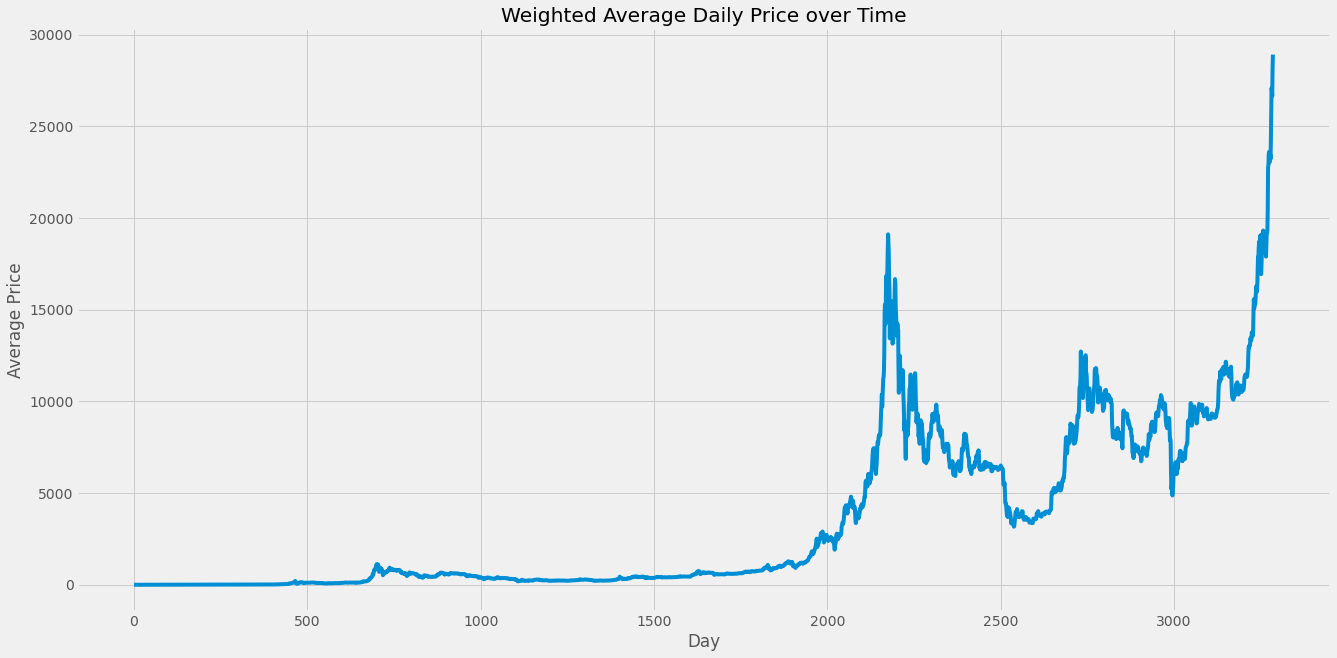

In [79]:
# plot the wieghted daily average
dailyData['WeightedDailyAvg'].plot(title='Weighted Average Daily Price over Time',xlabel='Day',ylabel='Average Price',figsize=(20,10))

<AxesSubplot:title={'center':'Percent change over time'}, xlabel='Day', ylabel='Average Price'>

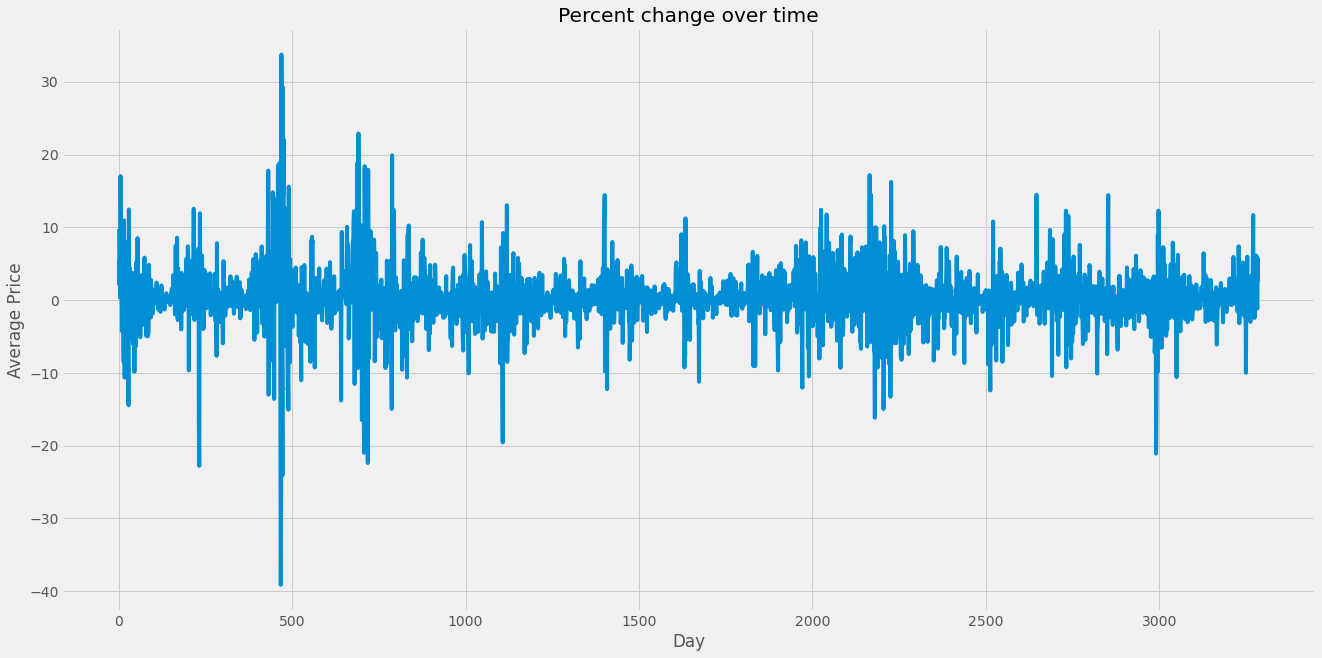

In [80]:

dailyData['PercentChange'].plot(title='Percent change over time',xlabel='Day',ylabel='Average Price',figsize=(20,10))

In [54]:
# declare a normalizer to normalize the data
normalizer = MinMaxScaler(feature_range=(0,1))

#normalize the data for training and validation
changeTrainData= normalizer.fit_transform(dailyData[
    ['Open','High','Low','Close','VolumeBTC','WeightedDailyAvg',
     'PercentChange','5DayAvg','10DayAvg','20DayAvg']].values)

In [55]:
# create training set and validation set. For all validation sets in this notebook, the validation
# set was made to be the last year of the historical Bitcoin data, which runs from January 1, 2020 until
# December 31, 2020.

pChange = normalizer.fit_transform(dailyData[['PercentChange']])

X_=[]
Y_=[]

for i in range(20,len(changeTrainData)-1):
        X_.append(np.array(changeTrainData[i]).flatten())
        Y_.append(pChange[i+1])
        
testSize = 365

XChange_train = np.array(X_[1500:len(X_)-testSize])
XChange_test = np.array(X_[len(X_)-testSize:])
YChange_train = np.array(Y_[1500:len(Y_)-testSize])
YChange_test = np.array(Y_[len(Y_)-testSize:])

assert (len(XChange_train)==len(YChange_train))
assert (len(XChange_test)==len(YChange_test))

XChange_test.shape

(365, 10)

In [21]:
# Build a fully connected dense NN that will predict the percent change in price for each date.

inputLayer = keras.layers.Input(10)
layer1 = keras.layers.Dense(1000, activation='relu')
drop1 = keras.layers.Dropout(0.1)
layer2 = keras.layers.Dense(1000, activation='relu')
drop2 = keras.layers.Dropout(0.1)
layer3 = keras.layers.Dense(500, activation='relu')
drop3 = keras.layers.Dropout(0.1)
layer4 = keras.layers.Dense(200, activation='relu')
drop4 = keras.layers.Dropout(0.1)
layer5 = keras.layers.Dense(100, activation='relu')
drop5 = keras.layers.Dropout(0.1)
layer6 = keras.layers.Dense(50, activation='relu')
drop6 = keras.layers.Dropout(0.1)
outLayer = keras.layers.Dense(1)

modelLayers = [inputLayer,layer1,layer2,layer3,layer4,layer5,layer6,outLayer]

model = keras.Sequential(layers=modelLayers)

# compile model and show summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              11000     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5

In [666]:
saveModel = keras.callbacks.ModelCheckpoint(filepath ='./DenseChange1', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

# train the model
model.fit(XChange_train, YChange_train, epochs=300,
           validation_data=(XChange_test, YChange_test), callbacks=[saveModel, earlyStopping])

Epoch 1/300
44/44 [==============================] - 1s 31ms/step - loss: 0.0214 - val_loss: 0.0024
Epoch 2/300
44/44 [==============================] - 1s 30ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 3/300
44/44 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 4/300
44/44 [==============================] - 1s 29ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 5/300
44/44 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 6/300
44/44 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/300
44/44 [==============================] - 1s 29ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 8/300
44/44 [==============================] - 1s 29ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/300
44/44 [==============================] - 1s 29ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 10/300
44/44 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0019
Epo

In [56]:
# load the version of the model that performed the best on the validation data
model = keras.models.load_model('./DenseChange1')

# have model predict for the validation data
predsChange = model.predict(XChange_test)

In [57]:
# Reverse the normalization of the data for viewing. 
predsChange = normalizer.inverse_transform(predsChange)
Ytest_graph = normalizer.inverse_transform(YChange_test)

predsChange[0,0]

0.36599284

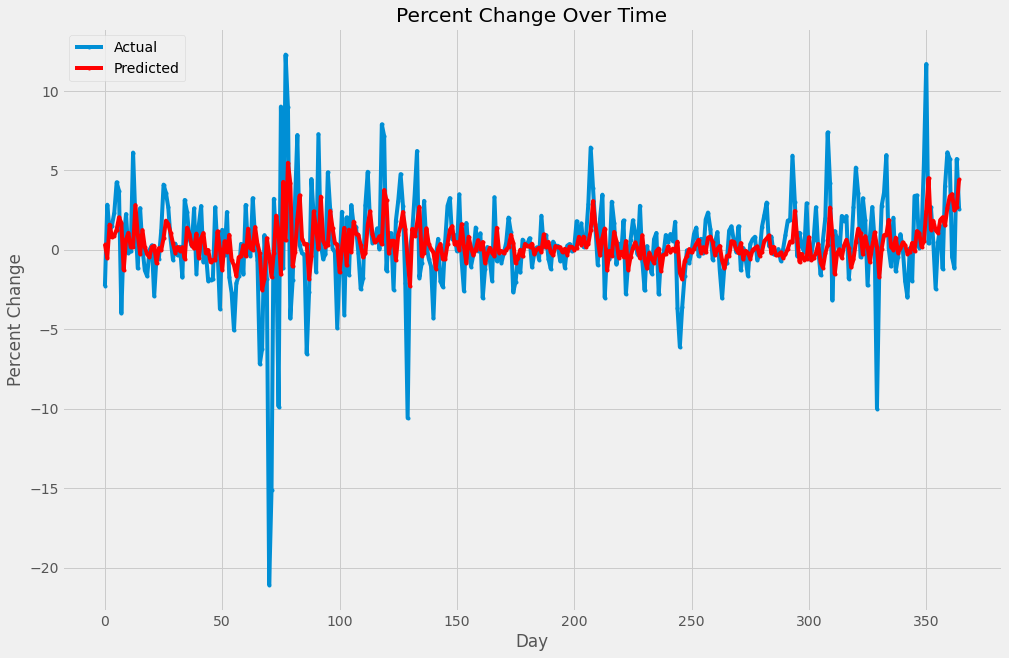

In [82]:
# plot the model's predictions against the actual percent change
plt.figure(figsize=(15,10))
plt.plot(Ytest_graph, marker='.', label="Actual")
plt.plot(predsChange, marker='.', label="Predicted", color='red')
plt.xlabel('Day')
plt.ylabel('Percent Change')
plt.title('Percent Change Over Time')
plt.legend()

In [27]:
# Define function for a 'Naive Trader'. This simulates a simple buy-and-hold strategy in which the 
# agent buys Bitcoin on the first day of the given time peroid and then sells all Bitcoin on the last
# day of the given time period. 
def naiveTrader(money, dailyChange):
    for c in dailyChange:
        money += money*(c/100)
    return money
   
# Define function for an 'Allegedly Smart Trader'. This simulates a trader who uses the predictions from the 
# model to guide a trading strategy. If the model predicts the a positive percent change, the trader will
# buy bitcoin at the opening price of that day and then sell all bitcoin at the closing price of that day. 
# If the model was correct, and the price increased, the trader will profit. If the model is incorrect
# and the price dropped the trader will lose money. When the model predicts the a negative percent change
# the trader will simply hold for the day.
def allegedlySmartTrader(money, dailyChange, predictedChange):
    for actC, predC in zip(dailyChange, predictedChange):
        if predC > 0:
            money += money*(actC/100)
            
    return money


# Simulate trading for 1 year. Each trading agent begins the year with $100 dollars and follows their 
# assigned trading strategy.
buyAndHold = naiveTrader(100, Ytest_graph)
tradeOnModel = allegedlySmartTrader(100, Ytest_graph, predsChange)

# Print the money for each strategy at the end of the year.
print('Buy and Hold Strategy: %.2f'%(buyAndHold))
print('Trading Strategy Based on Model: %.2f'%(tradeOnModel))

Buy and Hold Strategy: 401.78
Trading Strategy Based on Model: 513.58


In [63]:
# scale data
trainData= normalizer.fit_transform(dailyData[
    ['Open','High','Low','Close','VolumeBTC','WeightedDailyAvg',
     'PercentChange','5DayAvg','10DayAvg','20DayAvg']].values)

In [64]:
# create training and validation sets for model that will predict price
X_=[]
Y_=[]

for i in range(0,len(dailyData)-1):
        X_.append(np.array(trainData[i]).flatten())
        Y_.append(trainData[i+1][1])
        
testSize = 365

XDense_train = np.array(X_[1500:len(X_)-testSize])
XDense_test = np.array(X_[len(X_)-testSize:])
YDense_train = np.array(Y_[1500:len(Y_)-testSize])
YDense_test = np.array(Y_[len(Y_)-testSize:])

assert (len(XDense_train)==len(YDense_train))
assert (len(XDense_test)==len(YDense_test))

XDense_train[0]

array([0.01299923, 0.012967  , 0.01287705, 0.01292348, 0.05451021,
       0.01290983, 0.53125599, 0.0136445 , 0.01459618, 0.01593565])

In [31]:
# Create a fully-connected Dense NN that predicts daily high price.

inputLayer = keras.layers.Input(10)
layer1 = keras.layers.Dense(1024, activation='relu')
drop1 = keras.layers.Dropout(0.4)
layer2 = keras.layers.Dense(1024, activation='relu')
drop2 = keras.layers.Dropout(0.4)
layer3 = keras.layers.Dense(512, activation='relu')
drop3 = keras.layers.Dropout(0.4)
layer4 = keras.layers.Dense(256, activation='relu')
drop4 = keras.layers.Dropout(0.4)
layer5 = keras.layers.Dense(128, activation='relu')
drop5 = keras.layers.Dropout(0.4)
layer6 = keras.layers.Dense(64, activation='relu')
drop6 = keras.layers.Dropout(0.4)
outLayer = keras.layers.Dense(1)

modelLayers = [inputLayer,layer1,drop1,layer2,drop2,layer3,drop3,layer4,drop4,layer5,drop5,layer6,drop6,outLayer]

model2 = keras.Sequential(layers=modelLayers)

model2.compile(optimizer='adam', loss='mean_squared_error')

model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              11264     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)              

In [523]:
saveModel = keras.callbacks.ModelCheckpoint(filepath ='./Dense1', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

# train model
model2.fit(XDense_train, YDense_train, epochs=300,
           validation_data=(XDense_test, YDense_test), callbacks=[saveModel, earlyStopping])

Epoch 1/300
45/45 [==============================] - 2s 42ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 2/300
45/45 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 3/300
45/45 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0094
Epoch 4/300
45/45 [==============================] - 2s 42ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 5/300
45/45 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 6/300
45/45 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 7/300
45/45 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 8/300
45/45 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 9/300
45/45 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 10/300
45/45 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 1

In [65]:
# Load best model and predict on validation set
denseModel = keras.models.load_model('./Dense1')
predsDense = denseModel.predict(XDense_test)
predsDense = [x[0] for x in predsDense]

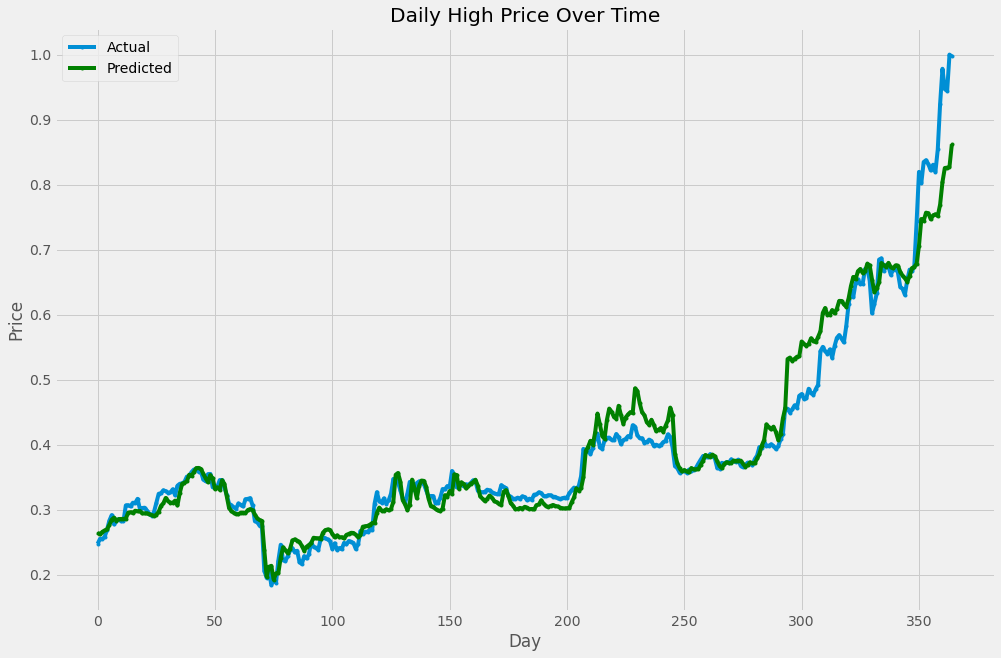

In [83]:
plt.figure(figsize=(15,10))
plt.plot(YDense_test, marker='.', label="Actual")
plt.plot(predsDense, marker='.', label="Predicted", color='green')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Daily High Price Over Time')
plt.legend()

In [67]:
# Function to simulate a buy and hold strategy
def naiveTrader2(money, prices):
    shares = money/prices[0]
    return shares*prices[-1]

def mediocreTrader(money, prices):
    for i in range(1, len(prices)-1):
        if prices[i] > prices[i-1]:
            money = (money/prices[i])*prices[i+1]
    
    return money

# Function to simulate a trading strategy based on the model's prediction
def allegedlySmartTrader2(money, prices, predictedPrices):
    assert len(prices) == len(predictedPrices)
    
    for i in range(len(prices)-1):
        if predictedPrices[i+1] > predictedPrices[i]:
            money = (money/prices[i])*prices[i+1]

    return money
            
buyAndHold = naiveTrader2(100, YDense_test)
tradeOnModel = allegedlySmartTrader2(100, YDense_test, predsDense)

print('Buy and Hold Strategy: %.2f'%(buyAndHold))
print('Trading Strategy Based on Model: %.2f'%(tradeOnModel))

        

Buy and Hold Strategy: 402.81
Trading Strategy Based on Model: 698.43


In [68]:
# Create training and validation sets for Recurrent NN

testSize = 365
X_=[]
Y_=[]

for i in range(20,len(dailyData)-1):
        X_.append(np.array(trainData[i-10:i+1]))
        Y_.append(trainData[i+1][1])
        


Xlstm_train = np.array(X_[1500:len(X_)-testSize])
Xlstm_test = np.array(X_[len(X_)-testSize:])
Ylstm_train = np.array(Y_[1500:len(Y_)-testSize])
Ylstm_test = np.array(Y_[len(Y_)-testSize:])

#Xlstm_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#Xlstm_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Xlstm_train.shape

(1400, 11, 10)

In [39]:
# Build a Recurrent NN that uses LSTM layers to predict High Price from the previous 10 days
# of Bitcoin data price information

timesteps = Xlstm_train.shape[1]
features = Xlstm_train.shape[2]

recurrentNN = keras.Sequential()

recurrentNN.add(keras.layers.LSTM(units=512, return_sequences=True, input_shape=(timesteps, features)))
recurrentNN.add(keras.layers.Dropout(0.2))
recurrentNN.add(keras.layers.LSTM(units=256, return_sequences=True))
recurrentNN.add(keras.layers.Dropout(0.2))
recurrentNN.add(keras.layers.LSTM(units=128, return_sequences=True))
recurrentNN.add(keras.layers.Dropout(0.3))
recurrentNN.add(keras.layers.LSTM(units=64, return_sequences=False))
recurrentNN.add(keras.layers.Dropout(0.3))
recurrentNN.add(keras.layers.Dense(units=32, activation='relu'))
recurrentNN.add(keras.layers.Dropout(0.3))
recurrentNN.add(keras.layers.Dense(units=1))              

recurrentNN.compile(optimizer='adam', loss='mean_squared_error')

recurrentNN.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 11, 512)           1071104   
_________________________________________________________________
dropout_12 (Dropout)         (None, 11, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 256)           787456    
_________________________________________________________________
dropout_13 (Dropout)         (None, 11, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 11, 128)           197120    
_________________________________________________________________
dropout_14 (Dropout)         (None, 11, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)               

In [622]:
saveModelRecurrent = keras.callbacks.ModelCheckpoint(filepath ='./Recurrent2', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

# Train model
recurrentNN.fit(Xlstm_train, Ylstm_train, epochs=200, validation_data=(Xlstm_test, Ylstm_test), 
                callbacks=[saveModelRecurrent, earlyStopping])

Epoch 1/200
44/44 [==============================] - 34s 765ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 2/200
44/44 [==============================] - 33s 741ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 3/200
44/44 [==============================] - 4s 93ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 4/200
44/44 [==============================] - 4s 94ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 5/200
44/44 [==============================] - 33s 752ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/200
44/44 [==============================] - 4s 92ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 7/200
44/44 [==============================] - 34s 762ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 8/200
44/44 [==============================] - 4s 90ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 9/200
44/44 [==============================] - 4s 90ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 10/200
44/44 [==============================] - 4s 91ms/step - loss: 0.0018 - val_loss

44/44 [==============================] - 60s 1s/step - loss: 9.7603e-04 - val_loss: 2.7039e-04
Epoch 69/200
44/44 [==============================] - 7s 151ms/step - loss: 0.0011 - val_loss: 5.4726e-04
Epoch 70/200
44/44 [==============================] - 7s 150ms/step - loss: 0.0011 - val_loss: 9.8488e-04
Epoch 71/200
44/44 [==============================] - 7s 150ms/step - loss: 0.0011 - val_loss: 6.9639e-04
Epoch 72/200
44/44 [==============================] - 7s 148ms/step - loss: 0.0012 - val_loss: 9.1413e-04
Epoch 73/200
44/44 [==============================] - 7s 149ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 74/200
44/44 [==============================] - 7s 150ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 75/200
44/44 [==============================] - 7s 149ms/step - loss: 9.6122e-04 - val_loss: 0.0015
Epoch 76/200
44/44 [==============================] - 7s 149ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 77/200
44/44 [==============================] - 7s 150ms/step -

In [69]:
# Load best RNN model and predict on validation set
lstmModel = keras.models.load_model('./Recurrent2')
predsLSTM = lstmModel.predict(Xlstm_test)
predsLSTM = [x[0] for x in predsLSTM]


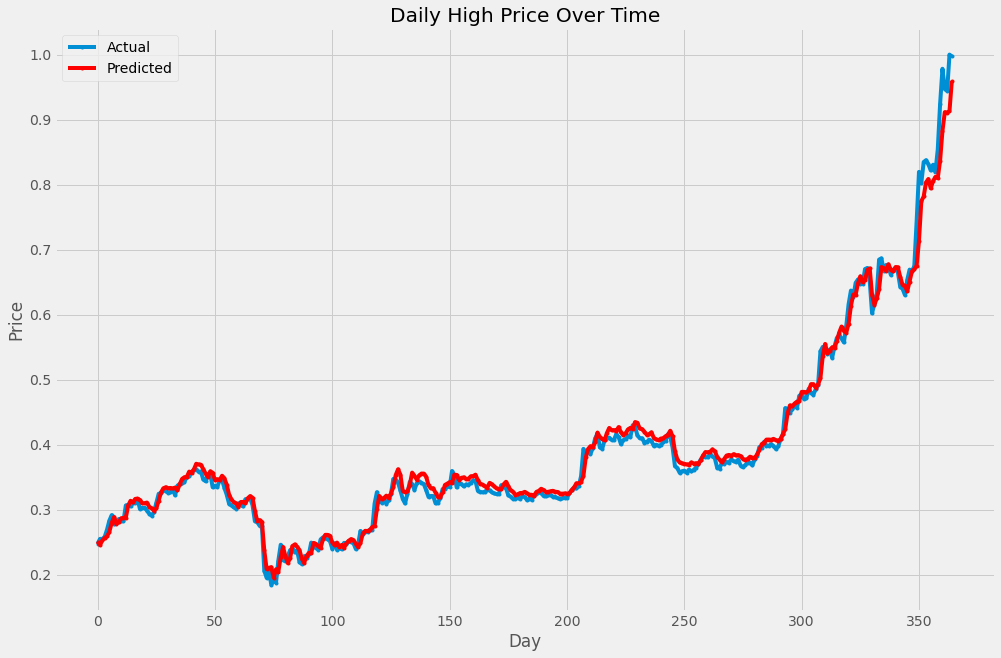

In [84]:
plt.figure(figsize=(15,10))
plt.plot(Ylstm_test, marker='.', label="Actual")
plt.plot(predsLSTM, marker='.', label="Predicted", color='red')
plt.title('Daily High Price Over Time')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()

In [71]:
# Simulate trading
buyAndHold = naiveTrader2(100, Ylstm_test)
tradeOnModel = allegedlySmartTrader2(100, Ylstm_test, predsLSTM)


print('Buy and Hold Strategy: %.2f'%(buyAndHold))
print('Trading Strategy Based on Model: %.2f'%(tradeOnModel))

Buy and Hold Strategy: 402.81
Trading Strategy Based on Model: 681.91


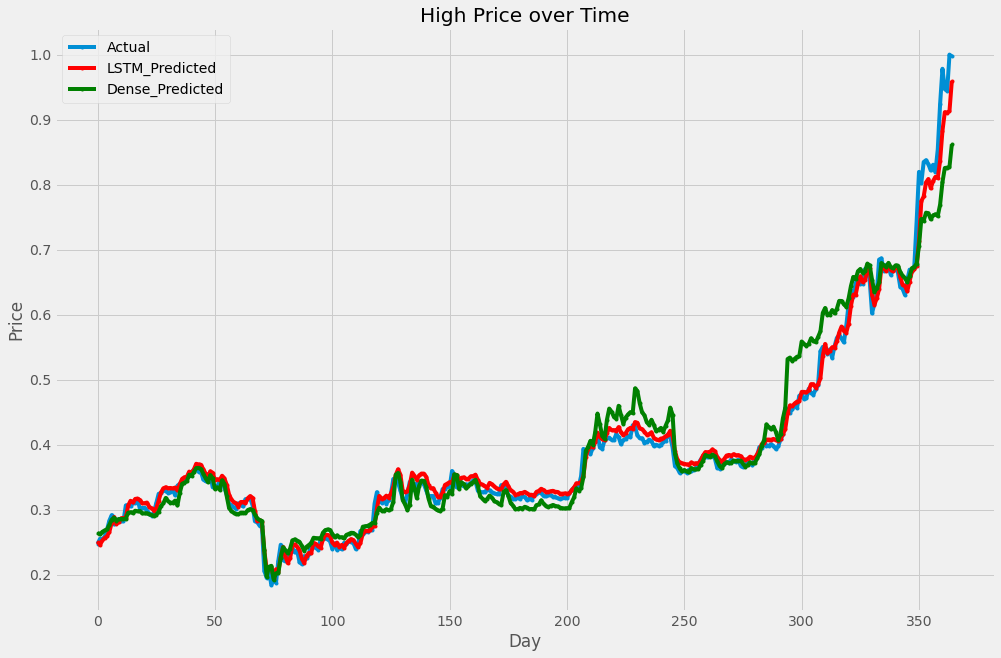

In [85]:
# Plot actual price, predictions from DNN, and predictions from RNN

plt.figure(figsize=(15,10))
plt.plot(Ylstm_test, marker='.', label="Actual")
plt.plot(predsLSTM, 'r', marker='.', label="LSTM_Predicted")
plt.plot(predsDense, 'g', marker='.', label="Dense_Predicted")
plt.title('High Price over Time')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()